In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans

import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM 
from keras.utils import np_utils
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from string import punctuation

import math
import os,sys
from scipy.io import arff
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from matplotlib import rcParams
import statsmodels.api as sm
import re
from skimage.color import rgb2gray

fixedrstate = 0
sns.set_style('white')
rcParams['figure.figsize'] = 11.7,8.27

import warnings
#from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=RuntimeWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. (Deep) CNN for Image Colorization

### a) Load the CIFAR-10 dataset

In [2]:
from PIL import Image
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
train_bird_indices = np.where(y_train==2)
test_bird_indices = np.where(y_test==2)

In [4]:
train_birds = X_train[train_bird_indices,:][0]
test_birds = X_test[test_bird_indices,:][0]

### b) Selecting Bird Images from Train and Test

In [5]:
train_birds.shape
test_birds.shape
X = np.concatenate((train_birds,test_birds),0)

In [6]:
#X[Image][row][col][r/g/b-0,1,2]
#X[:][:][:].flatten().shape#.shape

In [7]:
#plt.imshow(X_test[test_bird_indices,:][0][233])
#plt.imshow(X_kmeans[-1024:].reshape(32,32,3))

### c) Selecting all the pixels for clustering

In [8]:
# reshape it for clustering
X_kmeans = X.reshape(6144000,3)
X_kmeans

array([[164, 206,  84],
       [105, 140,  61],
       [118, 148, 101],
       ...,
       [156, 179,  95],
       [158, 180,  98],
       [157, 179,  98]], dtype=uint8)

In [9]:
#plt.imshow(X[0:1024].reshape(32,32,3))

### d)  Performing K means clustering with selected pixels vectors

In [10]:
kmeans = MiniBatchKMeans(n_clusters=4,random_state=0)
pred_clusters = kmeans.fit_predict(X_kmeans)

In [11]:
np.unique(pred_clusters,return_counts=False)

array([0, 1, 2, 3], dtype=int32)

In [12]:
cluster_centers = kmeans.cluster_centers_/255 

In [13]:
# Turn on for using distinct colors instead of the centers (good idea for better visibility)
cluster_centers = np.array([[0,0,128],[230, 25, 75],[170, 255, 195],[192, 192, 192]])/255

NOTE : The above part does not change the clustering in any way, we simply substitute different colors to represent the pixels for better visibility when comparing our results.
Reason for having to do this is that the RGB values in the original cluster centers are very close and using these colors show a very dull/grayscale like image (which makes it harder to visually compare our results)

In [14]:
new_pixels=np.ndarray(X_kmeans.shape)#np.zeros(X.shape)
one_hot_encoded_pixels = []
for i in range(pred_clusters.shape[0]):
    new_pixels[i]=(np.array(cluster_centers[pred_clusters[i]]))
    ohe_vector = np.zeros(4)
    ohe_vector[pred_clusters[i]] = 1 
    one_hot_encoded_pixels.append(ohe_vector) 

In [15]:
new_pixels.shape
#one_hot_encoded_pixels[0]

(6144000, 3)

In [16]:
# 4 classes representing each of 4 main_colors
np.unique(one_hot_encoded_pixels,axis=0)

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

In [17]:
one_hot_encoded_pixels = np.reshape(one_hot_encoded_pixels,(6000,32*32*4))
one_hot_encoded_pixels_train = np.reshape(np.array(one_hot_encoded_pixels[:5000]),(5000,32,32,4))
one_hot_encoded_pixels_test = np.reshape(np.array(one_hot_encoded_pixels[5000:]),(1000,32,32,4))

In [18]:
new_images = new_pixels.reshape(6000,32,32,3)
#y_train = new_pixels[0:5120000]
#y_test = new_pixels[5120000:]

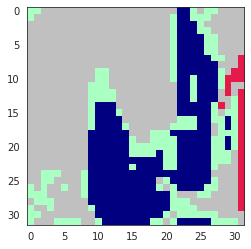

In [19]:
plt.imshow(new_images[5000])

### e) Convert RGB images to Grayscale

In [20]:
X_grayscale=np.zeros(shape=(6000,32,32))
for i in range(6000):
    original = X[i]
    X_grayscale[i] = rgb2gray(original)

In [21]:
X_grayscale.shape

(6000, 32, 32)

In [22]:
#original = X[i]
#grayscale = rgb2gray(original)
#plt.imshow(grayscale,cmap=plt.cm.gray)

In [23]:
# Prepare Train and Test Images
X_train_grayscale = X_grayscale[0:5000].reshape((5000,32,32,1))
X_test_grayscale = X_grayscale[5000:].reshape((1000,32,32,1))

In [24]:
X_train_grayscale.shape

(5000, 32, 32, 1)

In [25]:
X_test_grayscale.shape

(1000, 32, 32, 1)

### f) CNN 

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

In [27]:
cnn = Sequential()

In [28]:
#Good Model - learns slowly but lighter (less parameters)
# cnn.add(tf.keras.layers.Conv2D( 128 ,(5,5),strides=1,padding='same',input_shape=(32,32,1),activation='relu' ))
# cnn.add(tf.keras.layers.MaxPooling2D( (2,2),strides=1,padding='same'   ))
# cnn.add(tf.keras.layers.Conv2D( 128 ,(5,5),strides=1,padding='same' ,activation='relu'   ))
# cnn.add(tf.keras.layers.MaxPooling2D( (2,2),strides=1,padding='same'   ))
# cnn.add(tf.keras.layers.Flatten())
# cnn.add(tf.keras.layers.Dense(512, activation='relu'))
# cnn.add(tf.keras.layers.Dense(4096, activation='softmax'))
# cnn.add(tf.keras.layers.Reshape( (32,32,4)))


# Better model - learns faster but heavier
cnn.add(tf.keras.layers.Conv2D( 256 ,(5,5),strides=1,padding='same',input_shape=(32,32,1),activation='relu' ))
cnn.add(tf.keras.layers.MaxPooling2D( (2,2),strides=1,padding='same'   ))
cnn.add(tf.keras.layers.Conv2D( 256 ,(5,5),strides=1,padding='same' ,activation='relu'   ))
cnn.add(tf.keras.layers.MaxPooling2D( (2,2),strides=1,padding='same'   ))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(2048, activation='relu'))
cnn.add(tf.keras.layers.Dense(4096, activation='softmax'))
cnn.add(tf.keras.layers.Reshape( (32,32,4)))

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 256)       6656      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       1638656   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              536872960 
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              8

In [30]:
# Checkpointing provision - use if required
filepath="cnn-weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [31]:
#Training the Model
epochs = 30
epochs_log = []
best_test_error = 100 # random high number
for i in range(epochs):
    print('Epoch :',i+1)
    epoch_history = cnn.fit(X_train_grayscale,one_hot_encoded_pixels_train,shuffle=True,epochs=1,validation_split=0.1,verbose=1)#,callbacks=callbacks_list)
    test_error = cnn.evaluate(X_test_grayscale,one_hot_encoded_pixels_test,verbose=1)[0]
   
    if best_test_error > test_error:
      best_test_error = test_error
      print('saving weights')
      cnn.save_weights('best-cnn-weights.hdf5')

    epochs_log.append({'epochs':i+1,'train_error':epoch_history.history['loss'][0],'validation_error':epoch_history.history['val_loss'][0],'test_error':test_error})

epochs_log = pd.DataFrame(epochs_log)

Epoch : 1
32/32 [==============================] - 1s 21ms/step - loss: 0.9159 - accuracy: 0.5942
saving weights
Epoch : 2
32/32 [==============================] - 1s 19ms/step - loss: 0.8215 - accuracy: 0.6341
saving weights
Epoch : 3
32/32 [==============================] - 1s 19ms/step - loss: 0.7662 - accuracy: 0.6603
saving weights
Epoch : 4
32/32 [==============================] - 1s 19ms/step - loss: 0.7588 - accuracy: 0.6593
saving weights
Epoch : 5
32/32 [==============================] - 1s 20ms/step - loss: 0.7142 - accuracy: 0.6837
saving weights
Epoch : 6
32/32 [==============================] - 1s 20ms/step - loss: 0.7044 - accuracy: 0.6891
saving weights
Epoch : 7
32/32 [==============================] - 1s 19ms/step - loss: 0.6787 - accuracy: 0.7020
saving weights
Epoch : 8
32/32 [==============================] - 1s 20ms/step - loss: 0.6917 - accuracy: 0.6962
Epoch : 9
32/32 [==============================] - 1s 19ms/step - loss: 0.6824 - accuracy: 0.7048
Epoch : 10
32

## Train, Validation and Test errors

In [32]:
# Tabulated train,validation and test errors per epoch
epochs_log

,epochs,train_error,validation_error,test_error
0,1,1.156032,0.899977,0.915870
1,2,0.854442,0.807864,0.821496
2,3,0.769997,0.747753,0.766151
3,4,0.715018,0.752654,0.758827
4,5,0.675915,0.708710,0.714153
5,6,0.638513,0.692646,0.704353
6,7,0.612970,0.665731,0.678716
7,8,0.573087,0.680892,0.691662
8,9,0.542157,0.673095,0.682424
9,10,0.508803,0.659100,0.667174


Text(0.5, 1.0, 'Train,Validation and Test Errors per epoch')

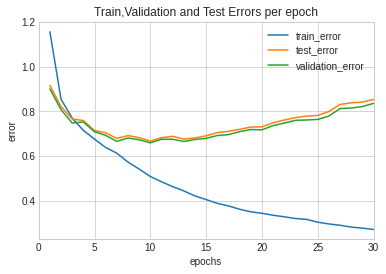

In [33]:
plt.style.use("seaborn-whitegrid")
epochs_log.plot('epochs',['train_error','test_error','validation_error'])
plt.xlim(0,30)
plt.ylabel('error')
plt.xlabel('epochs')
plt.title('Train,Validation and Test Errors per epoch')

From the above plot, we can observe the standard train vs test learning curve. With each increasing epoch, the model tries to estimate the train data even better and begins to overfit. A good training epoch number would be 10, around which we obtain the lowest test error. As expected, the validation closely follows the test error.

In [34]:
#Loading the best model - uncomment when required
#weights_file = 'best-cnn-weights.hdf5'
#cnn.load_weights(weights_file)
#cnn.compile(loss='categorical_crossentropy', optimizer='adam')

In [35]:
cnn.evaluate(X_test_grayscale,one_hot_encoded_pixels_test,verbose=1)#[0]

32/32 [==============================] - 1s 19ms/step - loss: 0.8534 - accuracy: 0.7119


[0.8533909916877747, 0.7118788957595825]

In [36]:
# conversion to the predicted image using softmax
def predicted_img(grayscale_img):
  res = cnn.predict(grayscale_img.reshape(1,32,32,1))

  resn = []
  for i in res[0]:
      argmax = np.argmax(i,axis=1)
      #print(argmax)
      resn.append(argmax)

  resimg = lambda x: cluster_centers[x]
  #plt.imshow(finalimg)
  finalimg = resimg(resn)
  return finalimg

In [37]:
#predicted_img(X_test_grayscale[4])#,predicted_img(X_test_grayscale[0])

In [38]:
#plt.imshow(new_images[5004])

In [39]:
#plt.imshow(X[5004])

### Visually Inspecting the arificially colored image with original images

Color | Grayscale | K-colored | Predicted


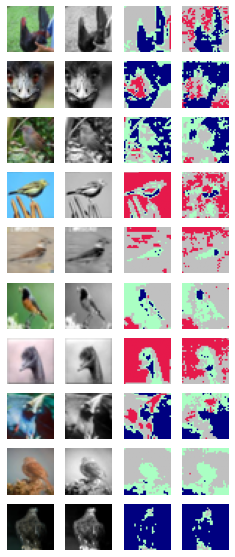

In [40]:
print('Color |','Grayscale |','K-colored |','Predicted')
fig = plt.figure(figsize=(4,10))
for i in range(40):
  axis = fig.add_subplot(10,4,i+1)
  if i%4==0:
    plt.imshow(X[5000+int(i/4)])
  elif i%4==1:
    plt.imshow(X_test_grayscale[int(i/4)].reshape(32,32),cmap='gray')
  elif i%4==2:
    plt.imshow(new_images[5000+int(i/4)])
  else:
    plt.imshow(predicted_img(X_test_grayscale[int(i/4)]))
  plt.axis('off')
plt.show()

* The 'Color' column shows the original 32x32 RGB images from the CIFAR-10 dataset
* The 'Grayscale' column shows the 32x32 images from the CIFAR-10 dataset converted to Grayscale. These are the inputs to our Convolutional Neural Network.
* The 'K-colored' column shows the images formed after k-means clustering (k=4) i.e the image made using just 4 main colors. This is what we are trying to predict as closely as possible using our CNN.
* The 'Predicted' columns show the predicted/output image of our CNN.

From the above we observe that we gained a sufficiently close representation using just 2 Convolutional layers, 2 maxpool, 2 MLP(dense) and a softmax output layer in 30 epochs (Flatten and reshape layers are added for convenient handling of the outputs)

This is a simplified task since only 4 colors were involved, We could experiment with a larger color gamut given the required processing power and further more complex architecture to obtain the original colored image as well.

### Citations & References
* https://stackoverflow.com/questions/47125723/keras-lstm-for-text-generation-keeps-repeating-a-line-or-a-sequence [1]
* https://en.wikipedia.org/wiki/Softmax_function#Reinforcement_learning [2]
* https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/ [3]
* https://numpy.org/doc/stable/reference/random/generated/numpy.random.multinomial.html [4]
* https://keras.io/api/layers/convolution_layers/convolution2d/ [5]
* https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/ [6]
* https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/ [7]
* https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html [8]